# Детектор пиков в одномерных спектрах

Сымитируем работу **датчика интенсивности**, то есть численной характеристики силы излучения. Предположим, что детектор измеряет интенсивность линейчатого спектра по 1000 последовательных частот.

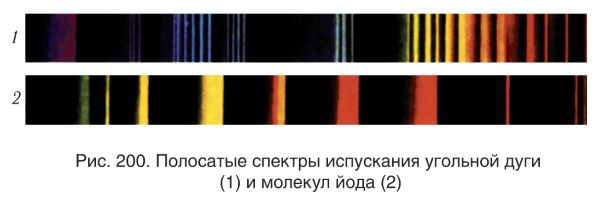

В окрестности нескольких частот появляются максимумы (пики), иногда асимметричные. В этих точках излучение можно наблюдать невооружённым глазом как свет определённого цвета. На иллюстрации ниже приведён схематичный график интенсивности для разных чисел $k$, для длин волн картина аналогична.

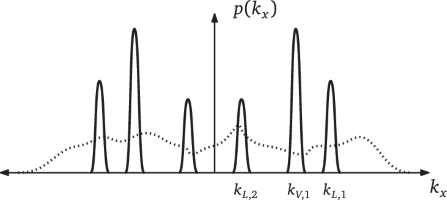

Сгенерируем синтетический датасет из $N$ таких сигналов длиной в 1000 значений. Каждый сигнал содержит случайное число пиков от $3$ до $10$. Пики имеют амплитуду и ширину, часть — асимметричные. Сигнал зашумлён, но нормирован по величине на отрезке $[0, 1]$. Значения размечены: ближайший к центру каждого пика получает метку $1$, остальные — $0$.


Импортируем необходимые библиотеки.

In [40]:
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

ROOT = Path("peaks_dataset_kaggle")
ROOT.mkdir(parents=True, exist_ok=True)
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

Зададим параметры датасета.

In [41]:
N_SAMPLES = 2000
SEQ_LEN = 1000
MIN_PEAKS = 3
MAX_PEAKS = 10

Функции для генерации одного нормально распределённого пика и полноценного сигнала.

In [42]:
def make_peak_profile(center, length, amp, left_sigma, right_sigma):
    xs = np.arange(length, dtype=np.float32)
    sig = np.where(xs <= center, left_sigma, right_sigma)
    profile = amp * np.exp(-0.5 * ((xs - center) ** 2) / (sig ** 2 + 1e-9))
    return profile

def generate_signal(length=SEQ_LEN):
    n_peaks = np.random.randint(MIN_PEAKS, MAX_PEAKS + 1)
    signal = np.zeros(length, dtype=np.float32)
    centers = []

    for _ in range(n_peaks):
        center = np.random.uniform(0, length - 1)
        amp = np.random.uniform(0.6, 2.0)
        if np.random.rand() < 0.35:
            left_sigma = np.random.uniform(2.0, 20.0)
            right_sigma = left_sigma * np.random.uniform(0.5, 2.5)
        else:
            left_sigma = right_sigma = np.random.uniform(2.0, 20.0)
        profile = make_peak_profile(center, length, amp, left_sigma, right_sigma)
        signal += profile
        centers.append(center)

    drift_amp = np.random.uniform(-0.25, 0.6)
    drift = drift_amp * np.sin(np.linspace(0, np.random.uniform(0.5, 2.2) * np.pi, length))
    noise = np.random.normal(0, 0.08, length).astype(np.float32)
    signal = signal + drift + noise
    signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-9)
    labels = np.zeros(length, dtype=np.uint8)

    for c in centers:
        idx = int(round(c))
        idx = max(0, min(length - 1, idx))
        labels[idx] = 1

    return signal.astype(np.float32), labels, centers

Сгенерируем и сохраним датасет на диск.

In [43]:
X = np.zeros((N_SAMPLES, SEQ_LEN), dtype=np.float32)
Y = np.zeros((N_SAMPLES, SEQ_LEN), dtype=np.uint8)

centers_list = []
for i in range(N_SAMPLES):
    s, lab, centers = generate_signal()
    X[i] = s
    Y[i] = lab
    centers_list.append([round(c, 3) for c in centers])

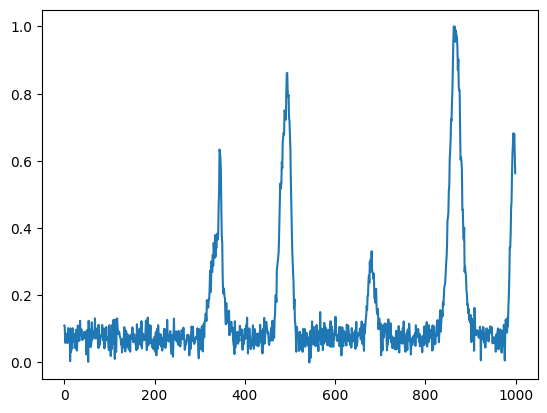

In [44]:
plt.plot(X[1])
plt.show()

In [45]:
np.savez_compressed(ROOT / "spectra_peaks.npz", X=X, Y=Y)

## Загрузка датасета на Kaggle

Сформируем JSON-описание набора данных согласно шаблону: название, описание и т. д. Сохраняем `dataset-metadata.json`.


In [46]:
description = {
  "title": "Synthetic Atomic Spectrum Peaks Dataset",
  "id": "alexzyukov/discrete-spectrum-peaks",
  "subtitle": "1000-frequency spectra, 3–10 peaks per sample, centers labelled",
  "description": "This data is synthetic, generated for educational purposes. Each sample is a normalized 1D-spectrum over 1000 frequency bins. 3–10 peaks are generated synthetically per sample; peaks may be asymmetric. Labels indicate the integer bin closest to the peak center (1/0 per bin).",
  "licenses": [
    {
      "name": "GPL-3.0",
      "url": "https://opensource.org/licenses/GPL-3.0"
    }
  ],
  "keywords": ["Spectrum", "Physics", "Intensity"]
}
with open(ROOT / "dataset-metadata.json", "w", encoding="utf-8") as f:
    json.dump(description, f, ensure_ascii=False, indent=2)

Сохраним метаданные о центрах пиков.

In [47]:
df = pd.DataFrame({
    "sample_id": np.arange(N_SAMPLES),
    "centers": [";".join(map(str, centers_list[i])) for i in range(N_SAMPLES)]
})
df.head()

,sample_id,centers
0,0,795.746;445.387;142.724;0.778;7.059;46.619;382...
1,1,336.559;497.698;995.338;679.548;867.404;345.58...
2,2,714.324;466.501;929.956;571.237
3,3,657.502;156.656;878.451;957.16;915.504;751.645...
4,4,428.216;996.521;242.015;46.946


In [48]:
df.to_csv(ROOT / "samples_metadata.csv", index=False)

In [49]:
from google.colab import files

uploaded = files.upload('/root/.config/kaggle')

Saving kaggle.json to /root/.config/kaggle/kaggle (1).json


In [50]:
!kaggle datasets create -p /content/peaks_dataset_kaggle

Starting upload for file spectra_peaks.npz
100% 6.86M/6.86M [00:00<00:00, 10.7MB/s]
Upload successful: spectra_peaks.npz (7MB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file samples_metadata.csv
100% 108k/108k [00:00<00:00, 189kB/s]
Upload successful: samples_metadata.csv (108KB)
Dataset creation error: Category already exists
